In [1]:
from ple.games.flappybird import FlappyBird
from ple import PLE
import numpy as np
import random
from IPython.display import clear_output
from datetime import datetime
import os
import glob
import shutil
import time
import matplotlib.pyplot as plt

couldn't import doomish
Couldn't import doom


In [2]:
help(FlappyBird)

Help on class FlappyBird in module ple.games.flappybird:

class FlappyBird(ple.games.base.pygamewrapper.PyGameWrapper)
 |  Used physics values from sourabhv's `clone`_.
 |  
 |  .. _clone: https://github.com/sourabhv/FlapPyBird
 |  
 |  
 |  Parameters
 |  ----------
 |  width : int (default: 288)
 |      Screen width. Consistent gameplay is not promised for different widths or heights, therefore the width and height should not be altered.
 |  
 |  height : inti (default: 512)
 |      Screen height.
 |  
 |  pipe_gap : int (default: 100)
 |      The gap in pixels left between the top and bottom pipes.
 |  
 |  Method resolution order:
 |      FlappyBird
 |      ple.games.base.pygamewrapper.PyGameWrapper
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, width=288, height=512, pipe_gap=100)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  game_over(self)
 |      Gets the status of the game, returns True if game has hit a termina

In [14]:
start_time = time.time() #Utilisé pour regarder le temps écoulé lors de l'apprentissage

############################## Définition des paramètres, modifiables #############################
epochs = 50000 #Nombre de parties à jouer
gamma = 0.8 # discount factor 0.8 
alpha = 0.6 # learning rate 0.6
prob = 0.5 #proba de jouer None lors d'un mouvement aléatoire
epsilon = 0 # Initialisation d'epsilon (exploration/exploitation) #0 pour ne pas activer l'exploration aléatoire
print_delay = 100 #Tous les combien de jeux on affiche un résumé et on enregistre le Q
###################################################################################################

############## Initialisation de Q (Décommenter une ligne, commenter l'autre) :####################
#Q = {} # pour reprendre un apprentissage de 0

Q = np.load('Q.npy').item() # pour reprendre l'apprentissage à partir d'un Q existant
###################################################################################################

# Définition des fonctions utilisées et initialisation des variables

#Les récompenses de sortie de p.act(action):
reward_dict = { "positive": 1, "negative": 0.0, "tick": 0, "loss": -1000.0, "win": 0.0}

#Fonction qui prend le jeu en entrée, et retourne une chaîne de caractère caractérisant l'état, de la forme hXXvYYsZZ
#où XX représente l'écart horizontal entre l'oiseau et le prochain tuyau
#YY est l'écart vertical entre l'oiseau et le haut du prochain tuyau
#Les valeurs issues de l'état ont été divisées pour réduire le nombre d'états et améliorer l'apprentissage
def getstate(jeu):
    
    #Acquisition des états sous forme de liste:
    a = list(jeu.getGameState().values())
    
    #Ecart vertical entre l'oiseau et le haut du prochain tuyau, divisé par 10
    #Le +512 a été ajouté pour ne pas avoir de valeurs négatives,
    #ce qui n'as plus d'importance maintenant avec les chaines de
    #caractères utilisées pour stocker les états
    v_pos = np.int(np.round((a[0]-a[3]+512)/10))
    
    #différence de hauteur entre le prochain tuyau avec le tuyau d'après, divisé par 50 pour ne pas avoir trop d'état
    vpos_next = np.int(np.round((a[3]-a[6])/50))
    
    #Distance de l'oiseau au prochain tuyau (+20 idem précédemment) divisé par 10 également
    h_pos = np.int(np.round((a[2]+20)/10))

    
    #Vitesse verticale de l'oiseau, divisée par 2
    speed = np.int(np.round(a[1]/2))
        
    #Création de la chaîne de caractères utilisée pour stocker les états dans le Q:
    S = 'h'+np.str(h_pos)+'v'+np.str(v_pos)+'vn'+np.str(vpos_next)+'s'+np.str(speed)
    
    return S

# Variables utilisées pour voir l'évolution
scores = []
average = []
bests = []
games = []
average_min = 0 #score minimum moyen pour enregistrer le Q (évoluera par la suite)
    
#Initilisation du jeu "jeu" et du joueur "p"
jeu = FlappyBird()

#frame_skip = The number of times we skip getting observations while repeat an action
#num_steps = The number of times we repeat an action.
#force_fps = True pour ne pas jouer en temps réel (plus vite)
#display_screen = True pour afficher le déroulement de la partie en direct
#reward_values = This contains the rewards we wish to set give our agent

p = PLE(jeu, fps=30, frame_skip=1, num_steps=1, force_fps=True, display_screen=True, reward_values = reward_dict)

#Début des parties, on en joue un nombre : epochs
for i in range(epochs):
    
    #Réinitialisation du jeu
    p.reset_game()
    
    #Acquisition de l'état du jeu (s)
    S = getstate(jeu)
    
    #Début de la boucle, tant que la partie n'est pas finie :
    while(not jeu.game_over()):
        
        #Ajout de l'état dans Q si pas encore dedans
        if S not in Q:
            Q[S] = {None : 0, 119 : 0}
            
        #Choix de l'action à effectuer
        if (np.random.random() < epsilon): # On choisit une action au hasard
            if np.random.random() < prob: # proba prob de jouer l'action None
                action = None
            else:
                action = 119
        else: # On choisit la meilleure action, qui maximise Q(s,a)
            if Q[S][119] > Q[S][None]:
                action = 119
            else:
                action = None

        #On fait l'action "action" (a)
        r = p.act(action)
        
        #On observe la récompense liée à cette action
        if r == 0: #Dans ce cas l'oiseau est encore en vie, on donne une récompense de 1
            reward = 1
        elif r == 1: #L'oiseau a franchi un tuyau, on donne une récompense de  100
            reward = 100
        else: #L'oiseau a touché un tuyau, le sol ou le plafond, on fait reward = r = -1000 (cf reward_dict)
            reward = r
        
        # On observe le nouvel état new_S (s')
        new_S = getstate(jeu)
        
        # Si le nouvel état n'est pas dans Q, on l'ajoute
        if new_S not in Q:
            Q[new_S] = {None : 0, 119 : 0}

        # Recherche du max sur a' de Q(s',a')
        maxQ = np.maximum(Q[new_S][None],Q[new_S][119])
        
        #Actualisation de Q(s,a)
        Q[S][action] = Q[S][action] + alpha*(reward + gamma*maxQ - Q[S][action])      

        #On actualise l'état courant
        S = new_S
        
    #Après la fin de la partie, on ajoute le score final à la liste des scores
    scores.append(jeu.getScore()-reward_dict["loss"])
    
    # Mise à jour de la stratégie exploitation / exploration s'il y a lieu
    if epsilon > 0.2:
        epsilon -= (1.0/epochs)
        
    
        
    #Sauvegarde du Q courant, et affichage de quelques donnée pour suivre l'apprentissage
    if ((i+1)%print_delay) == 0:
        print("")
        print("Game #: %s" % (i+1,))
        print("Meilleur score sur les ",print_delay," derniers essais =", np.max(scores))
        print("Score moyen sur les ",print_delay," derniers essais =", np.mean(scores))
        elapsed_time = time.time() - start_time
        printime = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
        print("Temps écoulé : ", printime)
        print('Taille du dictionnaire des états = ', len(Q))
        average.append(np.mean(scores))
        bests.append(np.max(scores))
        games.append(i+1)
        if np.mean(scores) > average_min:
            dire = './Q_learning_saves/Q_moyenne_'+np.str(np.mean(scores))
            np.save(dire, Q)
            print('Save done avec moyenne: ' + np.str(np.mean(scores)))
            average_min = np.mean(scores)
        np.save('Q',Q)
        scores = []
    



Game #: 100
Meilleur score sur les  100  derniers essais = 104.0
Score moyen sur les  100  derniers essais = 13.5
Temps écoulé :  00:00:54
Taille du dictionnaire des états =  55621
Save done avec moyenne: 13.5

Game #: 200
Meilleur score sur les  100  derniers essais = 105.0
Score moyen sur les  100  derniers essais = 22.1
Temps écoulé :  00:02:12
Taille du dictionnaire des états =  55627
Save done avec moyenne: 22.1

Game #: 300
Meilleur score sur les  100  derniers essais = 175.0
Score moyen sur les  100  derniers essais = 24.12
Temps écoulé :  00:03:38
Taille du dictionnaire des états =  55630
Save done avec moyenne: 24.12

Game #: 400
Meilleur score sur les  100  derniers essais = 155.0
Score moyen sur les  100  derniers essais = 25.4
Temps écoulé :  00:05:14
Taille du dictionnaire des états =  55638
Save done avec moyenne: 25.4

Game #: 500
Meilleur score sur les  100  derniers essais = 212.0
Score moyen sur les  100  derniers essais = 24.56
Temps écoulé :  00:07:00
Taille du dic

KeyboardInterrupt: 

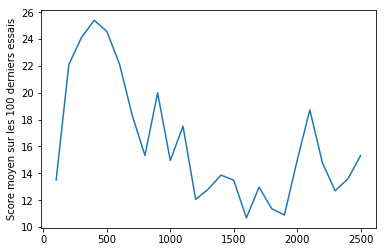

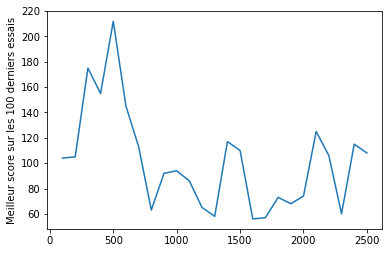

In [15]:
# Affichage des courbes des meilleurs scores et scores moyen lors des dernieres parties enregistrées

plt.plot(games,average)
plt.ylabel('Score moyen sur les 100 derniers essais')
plt.show()
plt.plot(games,bests)
plt.ylabel('Meilleur score sur les 100 derniers essais')
plt.show()


# Test du modèle
## Utilisation du même script que "run.py" utilisé pour la notation

In [10]:
import numpy as np
from ple.games.flappybird import FlappyBird
from ple import PLE
actions = [None, 119]
Q = np.load('Q_good.npy').item()


def getstate(state):
    
    a = list(state.values())
    v_pos = np.int(np.round((a[0]-a[3]+512)/10)) # Différence de position verticale entre l'oiseau et le bas du prochain tuyau
                          #+512 (hauteur totale en pixels) pour ne jamais être négatif
     #différence de hauteur entre le prochain tuyau avec le tuyau d'après, divisé par 50 pour ne pas avoir trop d'état
    vpos_next = np.int(np.round((a[3]-a[6])/50))
    h_pos = np.int(np.round((a[2]+20)/10)) #Distance de l'oiseau au prochain tuyau
    
    speed = np.int(np.round(a[1]/2))
    S = 'h'+np.str(h_pos)+'v'+np.str(v_pos)+'vn'+np.str(vpos_next)+'s'+np.str(speed)
    return S

def FlappyPolicy(state, screen):
    
    S = getstate(state)
    if S not in Q:
        action = None
    elif Q[S][119]>Q[S][None]:
        action = 119
    else:
        action = None
        
    return action


game = FlappyBird()
p = PLE(game, fps=30, frame_skip=1, num_steps=1, force_fps=False, display_screen=True)

p.init()
reward = 0.0

nb_games = 100
cumulated = np.zeros((nb_games))

for i in range(nb_games):
    p.reset_game()
    
    while(not p.game_over()):
        state = game.getGameState()
        screen = p.getScreenRGB()
        action=FlappyPolicy(state, screen) ### Your job is to define this function.
        
        reward = p.act(action)
        cumulated[i] = cumulated[i] + reward
    print('Game #', i, ' score :',cumulated[i]+5)

average_score = np.mean(cumulated+5)
max_score = np.max(cumulated+5)

print("Score moyen sur les 100 parties :", average_score)
print("Score max sur les 100 parties :", max_score)

if average_score > 15:
    print("YOU WOOOOOOOOOOOOOOOOOOON !!!!!")
else:
    print("Loser.")
        


Game # 0  score : 0.0
Game # 1  score : 10.0
Game # 2  score : 0.0


SystemExit: 

/home/ldeschamps/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
